In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('../data/ag_news_csv/test.csv', header=None)

In [3]:
from tqdm.autonotebook import tqdm

/home/fadeich/env3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [4]:
from model import CharCNN
import torch
from torch.autograd import Variable
from metric import print_f_score
import torch.nn.functional as F

In [5]:
import json
with open('../alphabet.json') as f:
    res = json.load(f)
num_features = len(res)

In [6]:
class Args():
    num_features = num_features
    dropout = 0.5
    test_path = '../data/ag_news_csv/test.csv'
    alphabet_path = '../alphabet.json'
    batch_size = 20
    num_workers = 4
args = Args()

In [7]:
char_model = CharCNN(args)
checkpoint = torch.load('../CharCNN_best.pth.tar')
char_model.load_state_dict(checkpoint['state_dict'])
char_model = char_model.to("cuda:0")

In [8]:
from data_loader_hotflip_beam import AGNEWs_HotFlip_Beam

In [9]:
test_dataset_beam = AGNEWs_HotFlip_Beam(per_corrupt=4, model=char_model, theta=0.5, k=1, dpp=False,
                                        label_data_path=args.test_path, alphabet_path=args.alphabet_path)

In [11]:
def get_picture(dataset, X, y):
    candidates, new_data, num_corrupt = dataset.corrupt_candidates(X, y)
    picture, pos = get_pic_beam_search(dataset, candidates, new_data, y, num_corrupt)
    vals, _, _ = zip(*sorted(candidates, key=lambda x: x[1]))
    return [vals] + picture, pos

In [14]:
def get_pic_beam_search(dataset, candidates, new_data, y, num_corrupt):
    k = 1
    picture = []
    memory = [(score, [y_ind], [new_char]) for score, y_ind, new_char in candidates]
    for i in range(num_corrupt-1):
        new_memory = []
        for current_score, y_inds, new_chars in memory[:k]:
            data = new_data.copy()
            new_val = np.zeros((len(dataset.alphabet), len(y_inds)))
            new_val[new_chars, np.arange(len(y_inds))] = 1
            data[:, y_inds] = new_val
            candidates_step, _, _ = dataset.corrupt_candidates(torch.from_numpy(data), y)
            for score_step, y_ind_step, new_char_step in candidates_step[:k]:
                new_memory.append((current_score + score_step, y_inds + [y_ind_step], new_chars + [new_char_step]))
            vals, _, _ = zip(*sorted(candidates_step, key=lambda x: x[1]))
            picture.append(vals)
        memory = sorted(new_memory, reverse=True)
    return picture, memory[0][1]

In [15]:
idx = 5
X = test_dataset_beam.oneHotEncode(idx)
y = test_dataset_beam.y[idx]
pic, pos = get_picture(test_dataset_beam, X, y)

In [18]:
arr_pic = np.array(pic)
i = 3

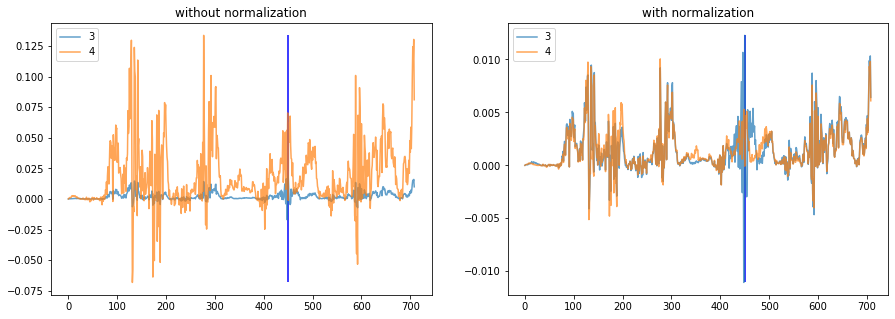

In [19]:
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
l1 = arr_pic[i]
l2 = arr_pic[i+1]
plt.title('without normalization')
plt.plot(l1, label=i, alpha=0.7)
plt.plot(l2, label=i+1, alpha=0.7)
ymin = min(np.min(l1), np.min(l2))
ymax = max(np.max(l1), np.max(l2))
plt.vlines(np.argmax(l1), ymax=ymax, ymin=ymin, color='b')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('with normalization')
l1 = arr_pic[i]/np.abs(np.sum(arr_pic[i]))
l2 = arr_pic[i+1]/np.abs(np.sum(arr_pic[i+1]))
plt.plot(l1, label=i, alpha=0.7)
plt.plot(l2, label=i+1, alpha=0.7)
ymin = min(np.min(l1), np.min(l2))
ymax = max(np.max(l1), np.max(l2))
plt.vlines(np.argmax(l1), ymax=ymax, ymin=ymin, color='b')
plt.legend()

In [23]:
x_ordered = []
matrix = []
n = arr_pic.shape[0]
for i in range(n):
    l1 = arr_pic[i]/np.abs(np.sum(arr_pic[i]))
    matrix.append(l1)
    if i != n - 1:
        x_ordered.append(np.argmax(l1))
change_nf = np.array(matrix)

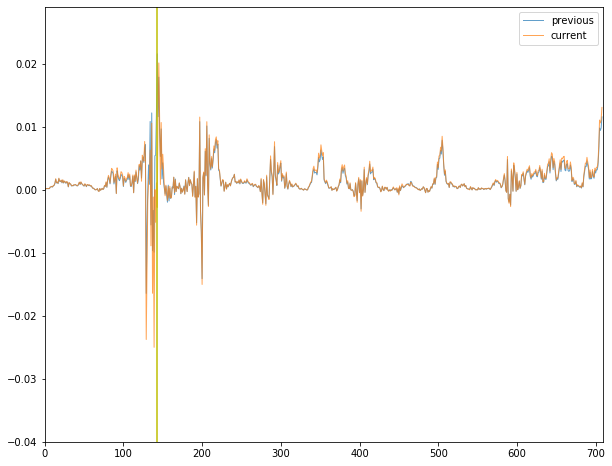

In [26]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


fig, ax = plt.subplots(figsize=(10,8))

ax.set_xlim((0, change_nf.shape[1]))
ax.set_ylim((np.min(change_nf), np.max(change_nf)))
line, = ax.plot([], [], lw=1, alpha=0.7, label='previous')
line3, = ax.plot([], [], lw=1, alpha=0.7, label='current')
line2 = ax.axvline(color="y")
ax.legend()

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    global line2
    x = np.arange(change_nf.shape[1])
    y = change_nf[i]
    line.set_data(x, y)
    line3.set_data(x, change_nf[i+1])
    if i != change_nf.shape[1] - 1:
        line2.set_xdata(x_ordered[i])
    return (line, line2, line3)


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=500, blit=True, frames=20)

HTML(ani.to_html5_video())
#HTML(ani.to_jshtml())